In [ ]:
!pip install underthesea py_vncorenlp accelerate datasets evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 35.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 45.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.8 MB/s eta 0:00:00
  Created wheel for py_vncorenlp: filename=py_vncorenlp-0.1.4-py3-none-any.whl size=4307 sha256=a985ab75f84fb109f12b752bd61cb8a9d3f80eea33f3a49ca3cc745ba2b48c74
  Stored in directory: /root/.cache/pip/wheels/d5/d9/bf/62632

In [ ]:
import os
os.environ['TORCH_USE_CUDA_DSA'] = '1'

In [ ]:
import urllib.request
from pathlib import Path
import zipfile
import re
from collections import defaultdict
import base64
import requests

import pandas as pd
import numpy as np
from underthesea import word_tokenize, text_normalize
import py_vncorenlp
from sklearn.model_selection import StratifiedKFold

from transformers import (AutoModel,
                          AutoTokenizer,
                          AutoModelForSequenceClassification,
                          TrainingArguments,
                          Trainer,
                          AutoModelForQuestionAnswering,
                          get_scheduler,
                          DataCollatorWithPadding,
                          logging)
import torch.nn as nn
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from accelerate import Accelerator
from datasets import Dataset
import evaluate
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

In [ ]:
HOME_PATH = os.getcwd()

In [ ]:
!mkdir vncorenlp

In [ ]:
py_vncorenlp.download_model(save_dir=HOME_PATH)

# Dataset

## Download and build

In [ ]:
def download_dataset():
  path = Path(HOME_PATH + "/sample_data/vi_readability_corpus.zip")
  if not path.is_file():
    url = "https://github.com/anvinhluong/Vietnamese-text-readability/raw/master/Vietnamese%20Text%20Readability%20Corpus.zip"
    urllib.request.urlretrieve(url, path)
    with zipfile.ZipFile(path, 'r') as corpus_ref:
      corpus_ref.extractall(HOME_PATH + "/sample_data/")

In [ ]:
download_dataset()

In [ ]:
DIFF_DICT = {"veryeasy": 0, "easy": 1, "medium": 2, "difficult": 3}

In [ ]:
def corpus_build():
  path = Path(HOME_PATH + "/sample_data/Vietnamese Text Readability Corpus")

  data = []
  label = []
  num = []

  for txt_file in path.glob("*.txt"):
    with open(txt_file, "r") as file:
      data.append(file.read())
      label.append(DIFF_DICT[re.split("[/_.]", txt_file.name)[0]])
      num.append(re.split("[/_.]", txt_file.name)[1])

  return pd.DataFrame(data = {"document": data, "labels": label})

In [ ]:
raw_data = corpus_build()

In [ ]:
raw_data.head(10)

,document,labels
0,Thi pháp học hiện đại trong nghiên cứu văn học...,3
1,"Công chúa ngủ trong rừng\nNgày xưa , có một ôn...",1
2,Cả nhà ăn dưa hấu\nGia đình nhà bạn Hùng có ba...,0
3,"Điện thoại\nVừa sắp sách vở ra bàn , Tường bỗn...",0
4,Cô bé và những chiếc nấm\nHai cô bé đi về nhà ...,0
5,Đắm thuyền\nNhững người đánh cá đi trên một co...,0
6,"Làm ơn\nNgày xưa , có một lời nói tí hon tên l...",1
7,Đổi mới tư duy lý luận trong khoa nghiên cứu v...,3
8,"Hoa Hồng Tặng Mẹ\nNhân ngày Lễ Hiền Mẫu , Hiếu...",0
9,Truyện cổ tích : Cô bé bán diêm\nRét dữ dội .\...,1


In [ ]:
# number of documents per level
difficulty_series = raw_data["labels"].value_counts()
difficulty_series

0    809
1    453
3    321
2    242
Name: labels, dtype: int64

## Preprocess

In [ ]:
rdrsegmenter = py_vncorenlp.VnCoreNLP(annotators=["wseg"], save_dir=HOME_PATH)

In [ ]:
def remove_special_character(text) -> str:
  """
  Ref: https://stackoverflow.com/questions/3819791/regex-in-vietnamese-characters
  """
  return " ".join(re.split(r"[^a-z0-9A-Z_ÀÁÂÃÈÉÊÌÍÒÓÔÕÙÚĂĐĨŨƠàáâãèéêìíòóôõùúăđĩũơƯĂẠẢẤẦẨẪẬẮẰẲẴẶẸẺẼỀỀỂưăạảấầẩẫậắằẳẵặẹẻẽềềểỄỆỈỊỌỎỐỒỔỖỘỚỜỞỠỢỤỦỨỪễếệỉịọỏốồổỗộớờởỡợụủứừỬỮỰỲỴÝỶỸửữựỳỵỷỹ]+", text))

In [ ]:
def processing_text(text):
  # first remove special character
  text = remove_special_character(text)
  # next lower text
  text = text.lower()
  # next normalize text using underthesea
  text = text_normalize(text)
  # finally segment word
  text = rdrsegmenter.word_segment(text)

  return text[0]

In [ ]:
process_data = raw_data.copy()

In [ ]:
process_data["document"] = process_data["document"].map(processing_text)

In [ ]:
process_data.head(10)

,document,labels
0,thi_pháp học hiện_đại trong nghiên_cứu văn_học...,3
1,công_chúa ngủ trong rừng ngày_xưa có một ông v...,1
2,cả nhà_ăn dưa_hấu gia_đình nhà bạn hùng có ba_...,0
3,điện_thoại vừa sắp sách_vở ra bàn tường bỗng n...,0
4,cô bé và những chiếc nấm hai cô bé đi về nhà v...,0
5,đắm thuyền những người đánh_cá đi trên một con...,0
6,làm_ơn ngày_xưa có một lời_nói tí_hon tên là l...,1
7,đổi_mới tư_duy l luận trong khoa nghiên_cứu vă...,3
8,hoa_hồng tặng mẹ nhân ngày lễ hiền_mẫu hiếu dừ...,0
9,truyện_cổ_tích cô bé bán diêm rét dữ_dội tuyết...,1


In [ ]:
'''
train_test_split before dividing text into sub-sequences
to reduce data leak
'''
train_set, test_set, _, __ = train_test_split(process_data, np.zeros(len(process_data)), train_size = 0.8, random_state = 42)

In [ ]:
#Sao lưu
train_set_limit_words = train_set.copy()
test_set_limit_words = test_set.copy()

In [ ]:
# next, make one document has maximum 254 words
def divine_to_chunk(ls, n):
  for i in range(0, len(ls), n):
    yield ls[i:i+n]

def limit_words(text):
  words = text.split()
  chunks = list(divine_to_chunk(words, 254)) #[CLS] [SEP]
  return [" ".join(chunk) for chunk in chunks]

In [ ]:
train_set_limit_words["document"] = train_set_limit_words["document"].map(limit_words)
test_set_limit_words["document"] = test_set_limit_words["document"].map(limit_words)


In [ ]:
#Explode to transform each element of a list-like to a row.
train_set_limit_words = train_set_limit_words.explode("document")
test_set_limit_words = test_set_limit_words.explode("document")

#Reset index for avoiding duplicate indexes
train_set_limit_words.reset_index(drop=True, inplace=True)
test_set_limit_words.reset_index(drop=True, inplace=True)

In [ ]:
print("Max length of a token in train set: ",max([len(doc.split(" ")) for doc in train_set_limit_words["document"]]))
print("Max length of a token in test set: ",max([len(doc.split(" ")) for doc in test_set_limit_words["document"]]))

print("Length of train set: ",len(train_set_limit_words))
print("Length of test set: ",len(test_set_limit_words))

print("Lables in train set: ", pd.Series(train_set_limit_words["labels"]).value_counts())
print("Lables in test set: ", pd.Series(test_set_limit_words["labels"]).value_counts())


Max length of a token in train set:  254
Max length of a token in test set:  254
Length of train set:  8621
Length of test set:  2299
Lables in train set:  3    4547
2    1866
1    1514
0     694
Name: labels, dtype: int64
Lables in test set:  3    1101
2     643
1     393
0     162
Name: labels, dtype: int64


# Train BERT

## Tokenize

In [ ]:
phobert = AutoModel.from_pretrained("vinai/phobert-base-v2")
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")

config.json:   0%|          | 0.00/678 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

In [ ]:
#Sử dụng Dataset của hugging face để giao tiếp với các mô hình trên Hugging Face dễ dàng hơn
train_dataset = Dataset.from_pandas(train_set_limit_words)
test_dataset = Dataset.from_pandas(test_set_limit_words)


In [ ]:
def tokenize(data) :
    return tokenizer(data['document'], truncation = True, max_length = 256, padding='max_length', add_special_tokens = True)

In [ ]:
tokenized_train_dataset = train_dataset.map(tokenize, batched = True)
tokenized_test_dataset = test_dataset.map(tokenize, batched = True)

Map:   0%|          | 0/8621 [00:00<?, ? examples/s]

Map:   0%|          | 0/2299 [00:00<?, ? examples/s]

In [ ]:
#Remove document before fed in model.
tokenized_train_dataset = tokenized_train_dataset.remove_columns(["document"])
tokenized_test_dataset = tokenized_test_dataset.remove_columns(["document"])

tokenized_train_dataset, tokenized_test_dataset

(Dataset({
     features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 8621
 }),
 Dataset({
     features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
     num_rows: 2299
 }))

In [ ]:
EPOCHS = 3
BATCH_SIZE = 32
LEARNING_RATE = 2e-5

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"
device

device(type='cuda')

## Model

**Tạo mô hình phân loại độ khó**

In [ ]:
class ReadibilityModel(nn.Module):
    def __init__(self, n_classes):
        super(ReadibilityModel, self).__init__()
        self.bert = phobert
        self.drop = nn.Dropout(p=0.2)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)

    def forward(self, **batch):
        output = self.bert(**batch)
        #[last_hidden_layer, pooler_output, all_hidden_layer] (batch, 256, 768) [CLS] 1 2 3 4 .. [SEP]
        x = self.drop(output[1])
        x = self.fc(x)
        return x

    def get_cls_embedding(self, **batch):
        output = self.bert(**batch)
        last_hidden_state = self.drop(output[0])
        cls_representation = last_hidden_state[0, 0, :]
        return cls_representation

**Tạo hàm train**

In [ ]:
def train(model, criterion, optimizer, train_loader):
    model.train()
    losses = []
    correct = 0

    for data in train_loader:
        data["input_ids"] = data["input_ids"].to(device)
        data["labels"] = data["labels"].to(device)
        data["token_type_ids"] = data["token_type_ids"].to(device)
        data["attention_mask"] = data["attention_mask"].to(device)
        targets = data.pop("labels")


        outputs = model(**data).to(device)
        loss = criterion(outputs, targets)
        _, pred = torch.max(outputs, dim=1)

        accelerator.backward(loss)
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        correct += torch.sum(pred == targets)
        losses.append(loss.item())
        f1_train.add_batch(references=targets, predictions = pred)


        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)


    print(f'Train Accuracy: {correct.double()/len(train_loader.dataset)} Loss: {np.mean(losses)} F1 {f1_train.compute(average="macro")}')

**Tạo hàm để evaluate**

In [ ]:
def eval(valid_loader,test_data = False):
    model.eval()
    losses = []
    correct = 0
    predicts = []
    labels = []

    with torch.no_grad():
        for data in valid_loader:
            data["input_ids"] = data["input_ids"].to(device)
            data["labels"] = data["labels"].to(device)
            data["token_type_ids"] = data["token_type_ids"].to(device)
            data["attention_mask"] = data["attention_mask"].to(device)
            targets = data.pop("labels")

            outputs = model(**data).to(device)
            _, pred = torch.max(outputs, dim=1)

            loss = criterion(outputs, targets)
            correct += torch.sum(pred == targets)
            losses.append(loss.item())
            f1_val.add_batch(references=targets, predictions = pred)
            predicts.extend(pred.cpu().numpy())
            labels.extend(targets.cpu().numpy())

    print(f'Valid Accuracy: {correct.double()/len(valid_loader.dataset)} Loss: {np.mean(losses)} F1 {f1_val.compute(average="macro")}')
    print(f'Classification report:')
    print(classification_report(labels, predicts))
    return correct.double()/len(valid_loader.dataset), confusion_matrix(labels, predicts)

**Chuẩn bị dataloader**

In [ ]:
def prepare_loaders(train_set, test_set, data_collator):
    train_loader = DataLoader(train_set, batch_size=16, shuffle=True, num_workers=2, collate_fn = data_collator)
    valid_loader = DataLoader(test_set, batch_size=16, shuffle=True, num_workers=2,  collate_fn = data_collator)

    return train_loader, valid_loader

In [ ]:
#Chuẩn bị dataloader, criterion, optimizer, learning rate scheduler,..
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_loader, valid_loader = prepare_loaders(tokenized_train_dataset, tokenized_test_dataset, data_collator= data_collator)
model = ReadibilityModel(n_classes=4).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
lr_scheduler = get_scheduler(name = "linear",
                            optimizer =optimizer ,
                            num_warmup_steps=0,
                            num_training_steps=EPOCHS*len(train_loader))
best_acc = 0

accelerator = Accelerator()
train_dataloader, val_dataloader, model, optimizer = accelerator.prepare(train_loader, valid_loader, model, optimizer)



In [ ]:
#Tiến hành train mô hình
for epoch in range(EPOCHS):
    print(f'Epoch {epoch+1}/{EPOCHS}')
    print('-'*30)
    f1_train = evaluate.load("f1")
    f1_val = evaluate.load("f1")
    train(model, criterion, optimizer, train_dataloader)
    val_acc, val_cf_matrix = eval(valid_loader = val_dataloader)

    if val_acc > best_acc:
        best_acc = val_acc

Epoch 1/3
------------------------------


Train Accuracy: 0.7842477670803851 Loss: 0.505792605785691 F1 {'f1': 0.6793829373068314}
Valid Accuracy: 0.8073075250108743 Loss: 0.4269180705046488 F1 {'f1': 0.7729256944526313}
Classification report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       162
           1       0.55      0.54      0.55       393
           2       0.68      0.74      0.71       643
           3       0.98      0.93      0.95      1101

    accuracy                           0.81      2299
   macro avg       0.77      0.77      0.77      2299
weighted avg       0.81      0.81      0.81      2299

Epoch 2/3
------------------------------
Train Accuracy: 0.8937478250782972 Loss: 0.2736066502271866 F1 {'f1': 0.8502603809406493}
Valid Accuracy: 0.8116572422792518 Loss: 0.43685350926696426 F1 {'f1': 0.7829587763438105}
Classification report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90       162
         

Confusion Matrix:
[[ 142   19    1    0]
 [  10  304   76    3]
 [   3  280  349   11]
 [   1   11   42 1047]]


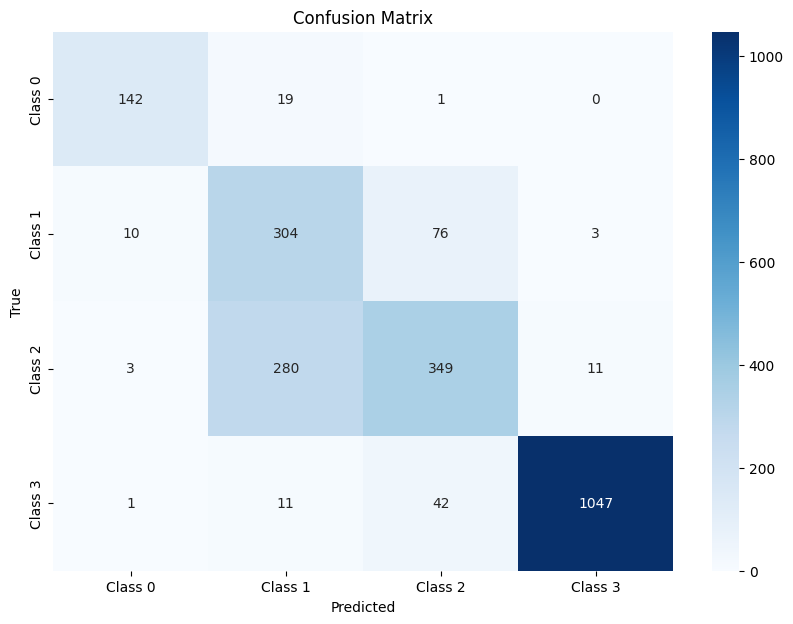

In [ ]:
# In confusion matrix
print("Confusion Matrix:")
print(val_cf_matrix)

# Vẽ confusion matrix bằng seaborn và matplotlib
plt.figure(figsize=(10, 7))
sns.heatmap(val_cf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'],
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## **EXTRACT FEATURES FROM FINE TUNED MODEL**

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, cross_val_score, KFold
#Train. 1 văn bản -> nhiều subsequence

In [ ]:
def get_CLS_embedding(text):
  text_list = limit_words(text)
  text_cls_embedding = np.zeros((1,768))
  for subseq in text_list:
    subseq_tokenized = tokenizer(subseq, truncation = True, max_length = 256, padding='max_length', add_special_tokens = True)
    # Chuyển các danh sách ID thành tensor PyTorch
    input_ids = torch.tensor(subseq_tokenized['input_ids']).unsqueeze(0).to(device)
    # Tạo tensor attention_mask
    attention_mask = torch.tensor(subseq_tokenized['attention_mask']).unsqueeze(0).to(device)

    subseq_cls_embedding = model.get_cls_embedding(input_ids = input_ids, attention_mask = attention_mask).cpu().detach().numpy()

    text_cls_embedding  += subseq_cls_embedding

  return text_cls_embedding.reshape(768)

In [ ]:
train_set["features"] = train_set["document"].map(get_CLS_embedding)
test_set["features"] = test_set["document"].map(get_CLS_embedding)

In [ ]:
X_train = np.vstack(train_set["features"].to_numpy())
y_train = train_set["labels"]
X_test = np.vstack(test_set["features"].to_numpy())
y_test = test_set["labels"]

In [ ]:
svm_model = SVC(kernel = "linear", gamma = "scale")

In [ ]:
svm_model.fit(X_train, y_train)
pred = svm_model.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       153
           1       0.82      0.84      0.83        91
           2       0.75      0.71      0.73        58
           3       0.98      1.00      0.99        63

    accuracy                           0.91       365
   macro avg       0.89      0.88      0.88       365
weighted avg       0.91      0.91      0.91       365



Confusion Matrix:
[[152   1   0   0]
 [  1  76  14   0]
 [  0  16  41   1]
 [  0   0   0  63]]


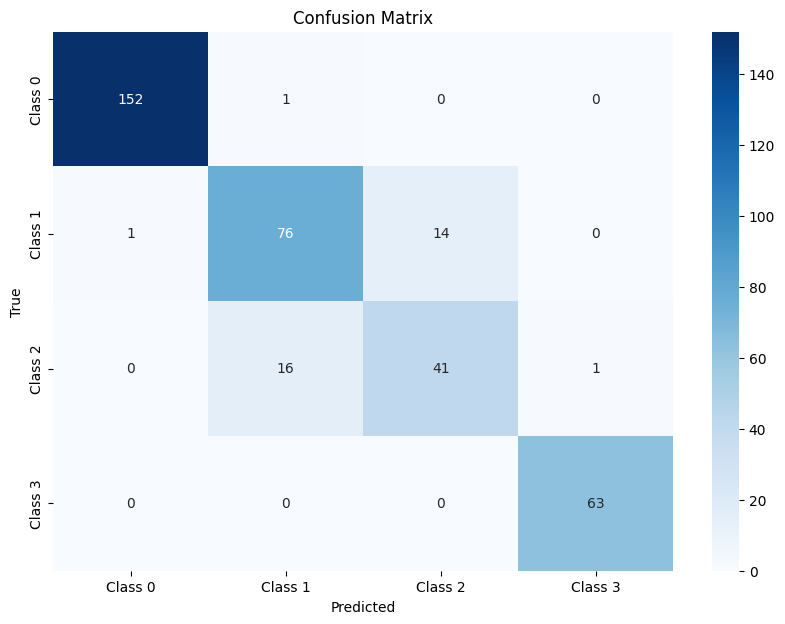

In [ ]:
cm = confusion_matrix(y_test, pred)

# In confusion matrix
print("Confusion Matrix:")
print(cm)

# Vẽ confusion matrix bằng seaborn và matplotlib
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'],
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()